In [1]:
!pip install tensorflow

In [2]:
!pip install tqdm

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph, Source
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import PIL
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [4]:
version = 12
folder = f"/Users/yaeerk/Documents/NAYA/FinalProject/QRcode{version}"

dataset_max_size = 30000

sub_folders = ("benign", "malware", "defacement", "phishing")
cnt_folders = (dataset_max_size * 3, dataset_max_size, dataset_max_size, dataset_max_size)               
cls_folders = (0, 1, 1, 1)
new_labels = ("benign", "malicious")

random_state = 43021
train_size = 0.8
epochs = 25
batch_size = 128
steps_per_epoch = dataset_max_size // batch_size

filename = f"{dataset_max_size}-{train_size}-{epochs}-{steps_per_epoch}-{version}"
save_path = "/tmp/qrcode/"

In [5]:
if(version == 4):
    image_size = (33, 33)
elif(version == 5):
    image_size = (37, 37)
elif(version == 6):
    image_size = (41, 41)
elif(version == 12):
    image_size = (65, 65)
else:
    image_size = (36, 36)

In [6]:
#https://www.kaggle.com/datasets/samahsadiq/benign-and-malicious-qr-codes

#load the dataset

try:

    #read the images
    with open(save_path + 'binary-qr-image-' + str(dataset_max_size), 'rb') as f:
        X = np.load(f)

    #read the labels
    with open(save_path + 'binary-qr-label-' + str(dataset_max_size), 'rb') as f:
        y = np.load(f)

    print(f"dataset was loaded")

except:
        
    X, y = [], []
        
    for p, sub_folder in enumerate(sub_folders):
                  
        X_subfolder, y_subfolder = [], []
            
        path = folder + "/" + sub_folder
        image_filenames = [filename for filename in os.listdir(path) if("png" in filename)]

        if(len(image_filenames) > cnt_folders[p]):        
            image_filenames = image_filenames[:cnt_folders[p]]

        for image_filename in tqdm(image_filenames, desc = "Loading " +  sub_folder, ncols = 110):

            try:
                m = Image.open(path + "/" + image_filename)

                #resize to predefined size
                m = m.resize(image_size, resample = PIL.Image.BICUBIC)

                #convert to gray scale
                m = ImageOps.grayscale(m)

                #convert to numpy array and do not rescale, save it in byte (smaller size on disk)
                n = np.array(m.getdata()).reshape(image_size[0], image_size[1], 1) / 255.0

                #append to datasets
                X_subfolder.append(n)                    
                y_subfolder.append(cls_folders[p])

            except:
                print(f"count not load: {image_filenames}")

        #rescale
        X.extend(X_subfolder)
        y.extend(y_subfolder)

    X = np.array(X)
    y = np.array(y)
              
    try:
        #save the images
        with open(save_path + 'binary-qr-image-' + str(dataset_max_size), 'wb') as f:
            np.save(f, X)

        #save the labels
        with open(save_path + 'binary-qr-label-' + str(dataset_max_size), 'wb') as f:
            np.save(f, y)

    except:
        print("unable to save images & labels")

dataset was loaded


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = random_state)

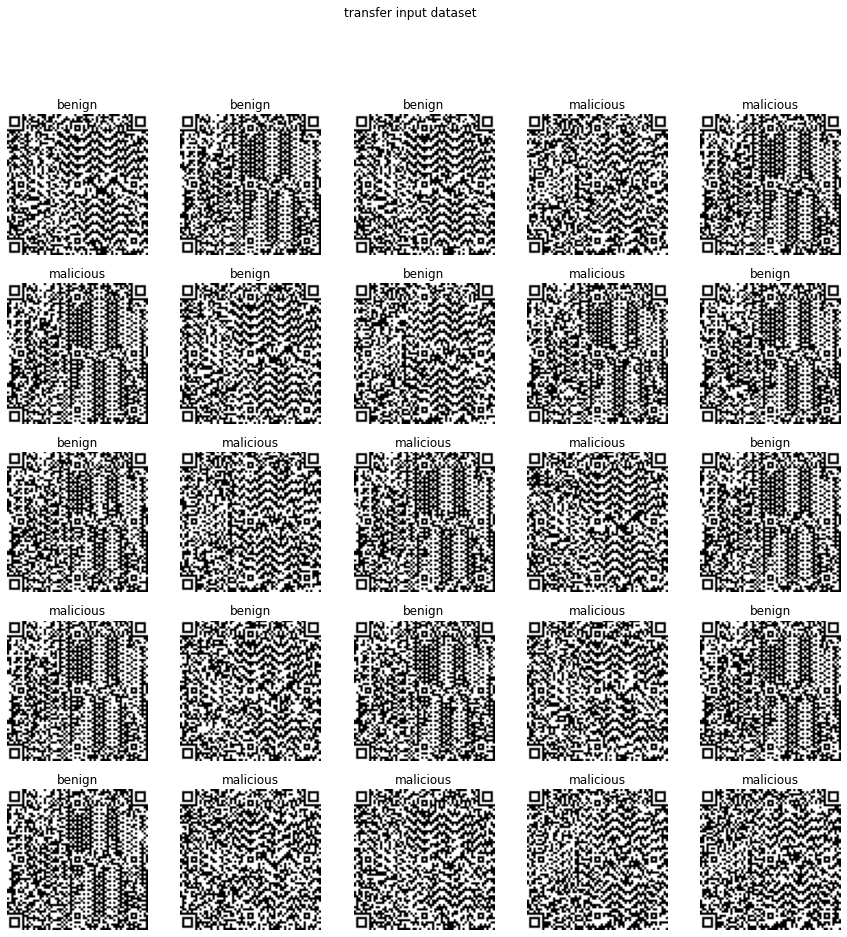

In [8]:
#visualize the input data
fig = plt.figure(figsize = (15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i], cmap = 'binary')
    plt.title(new_labels[y_test[i]])
    plt.axis("off")
    
fig.suptitle('transfer input dataset')
plt.savefig(save_path + "transfer-" + filename + "-visualization.png")
plt.show()

In [9]:
binaryclassifier = keras.models.load_model(save_path + "binary-classifier-" + filename)
binaryclassifier.pop()
binaryclassifier.trainable = False

transfer = tf.keras.Sequential([
    binaryclassifier,

    tf.keras.layers.Dense(image_size[0] * image_size[1], activation = "sigmoid"),
    tf.keras.layers.Reshape((image_size[0], image_size[1], 1)),

])
    
transfer.build((None, image_size[0], image_size[1], 1))

transfer.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"])

transfer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 12)                13892     
_________________________________________________________________
dense (Dense)                (None, 4225)              54925     
_________________________________________________________________
reshape (Reshape)            (None, 65, 65, 1)         0         
Total params: 68,817
Trainable params: 54,925
Non-trainable params: 13,892
_________________________________________________________________


In [10]:
history = transfer.fit(
    x = X_train, 
    y = X_train,
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch, 
    
    validation_data = (X_test, X_test),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)])

Epoch 1/25
234/234 [==============================] - 61s 260ms/step - loss: 0.5292 - binary_accuracy: 0.7280 - val_loss: 0.4952 - val_binary_accuracy: 0.7633
Epoch 2/25
234/234 [==============================] - 60s 258ms/step - loss: 0.4875 - binary_accuracy: 0.7680 - val_loss: 0.4814 - val_binary_accuracy: 0.7742
Epoch 3/25
234/234 [==============================] - 61s 260ms/step - loss: 0.4758 - binary_accuracy: 0.7762 - val_loss: 0.4709 - val_binary_accuracy: 0.7742
Epoch 4/25
234/234 [==============================] - 62s 265ms/step - loss: 0.4658 - binary_accuracy: 0.7794 - val_loss: 0.4613 - val_binary_accuracy: 0.7806
Epoch 5/25
234/234 [==============================] - 63s 269ms/step - loss: 0.4568 - binary_accuracy: 0.7815 - val_loss: 0.4526 - val_binary_accuracy: 0.7818
Epoch 6/25
234/234 [==============================] - 63s 271ms/step - loss: 0.4487 - binary_accuracy: 0.7827 - val_loss: 0.4448 - val_binary_accuracy: 0.7826
Epoch 7/25
234/234 [==========================

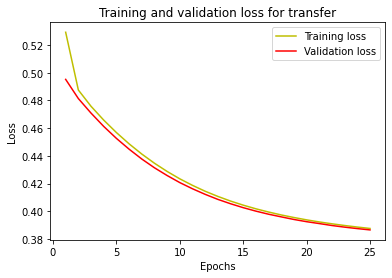

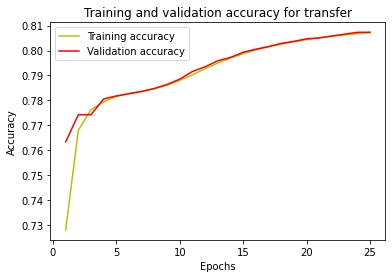

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1, len(loss) + 1)
plt.plot(epoch, loss, 'y', label = 'Training loss')
plt.plot(epoch, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss for transfer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_path + "transfer-" + filename + "-loss_vs_epoch.png")
plt.show()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(epoch, acc, 'y', label = 'Training accuracy')
plt.plot(epoch, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy for transfer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(save_path + "transfer-" + filename + "-accuracy_vs_epoch.png")
plt.show()

In [14]:
#get actual metrics of train data
score_train = transfer.evaluate(X_train, X_train)

#get actual metrics of test data
score_test = transfer.evaluate(X_test, X_test)

1125/1125 [==============================] - 17s 15ms/step - loss: 0.3865 - binary_accuracy: 0.8073


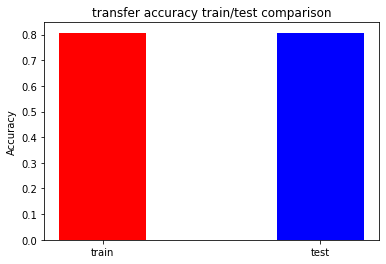

In [15]:
plt.bar(["train", "test"], 
        [score_train[1], score_test[1]],
        color =['red', 'blue'], width = 0.4)
 
plt.ylabel("Accuracy")
plt.title("transfer accuracy train/test comparison")
plt.savefig(save_path + "transfer-" + filename + "-train-test-accuracy.png")
plt.show()

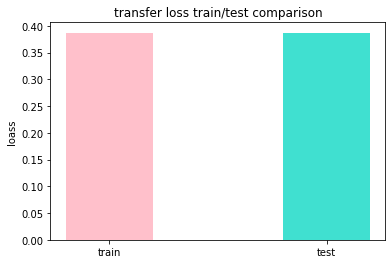

In [16]:
plt.bar(["train", "test"], 
        [score_train[0], score_test[0]],
        color =['pink', 'turquoise'], width = 0.4)
 
plt.ylabel("loass")
plt.title("transfer loss train/test comparison")
plt.savefig(save_path + "transfer-" + filename + "-train-test-loss.png")
plt.show()

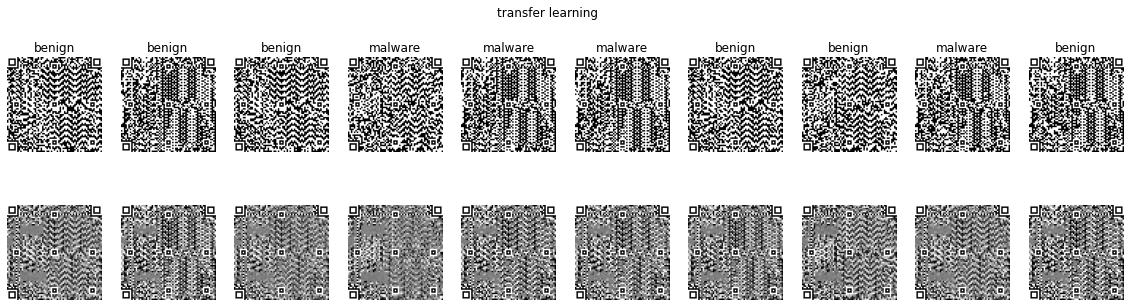

In [17]:
#visualize the transfer data
n = 10
y_transfer = transfer.predict(X_test[:n])
fig = plt.figure(figsize = (20, 5))

for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i], cmap = 'binary')
      
    plt.title(sub_folders[int(y_test[i])])    
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_transfer[i], cmap = 'binary')

    plt.axis("off")
    
fig.suptitle('transfer learning')
plt.savefig(save_path + "transfer-" + filename + "-learning.png")

In [ ]:
#transfer.save(save_path + "transfer-" + filename)